# HW6 Spike sorting
* Read this page: https://en.wikipedia.org/wiki/Spike_sorting#:~:targetText=Spike%20sorting%20is%20a%20class,neurons%20from%20background%20electrical%20noise. 
* Use dimensionality reduction techniques and clustering algorithms to identify groups of similar spikes
* For instance: 
    * TRY DIFFERENT THRESHOLDS TO EXTRACT SPIKES (change tf parameter)
    * DO PCA
    * DO KMEANs
    * Visualize average waveform associated to each spike: 
        * plt.plot(mean(waveform[labels==0], axis=0))
        
* How many waveforms (neurons/units) are there?
* Plot the clustering result against the first 2 principal components
* Plot the average waveform of each neuron overlaid

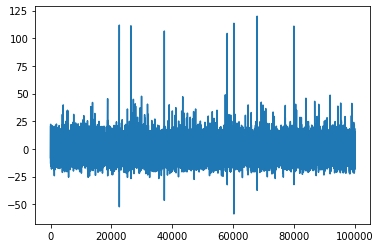

In [699]:
import numpy as np
import pylab as plt
trace = np.load('spike_sort/simulation_1.npy')
plt.plot(trace[:100000])
plt.show()

In [700]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    # extract spike waveforms
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]

    return spike_samp, wave_form

In [701]:
spike_samp, wave_form = get_spikes(trace, tf=6.09)

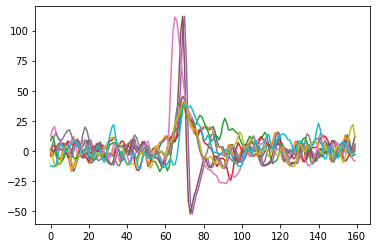

In [702]:
plt.plot(wave_form[:10].T)

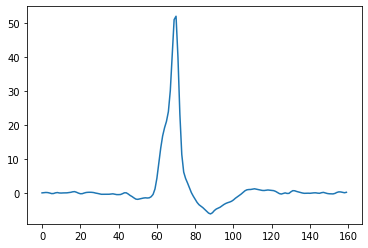

In [703]:
plt.plot(wave_form[:].mean(axis=0))

# PCA

In [741]:
from sklearn.decomposition import PCA

pca = PCA(n_components=45)
X_reduced = pca.fit_transform(wave_form.T)

Now we plot the first two priniciple components against each other and see that there are three separate neurons in our data

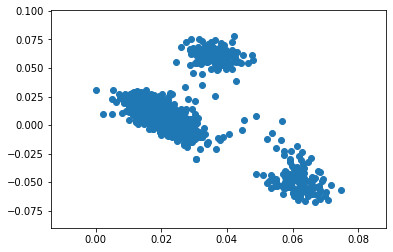

In [742]:
plt.scatter(pca.components_[0],pca.components_[1])

In [731]:
#pca = PCA(n_components = 45)
#X_reduced2 = pca.fit_transform(wave_form.T) # transpose because we are interested in most important waveforms
#X_reduced2.shape

(160, 45)

In [746]:
#plt.plot(X_reduced2.T[0])
#plt.plot(X_reduced2.T[1])
#plt.plot(X_reduced2.T[2])

# KMEANS

Here I use KMeans to separate neural units by spike shape.

Two functions were written:
   1. plotSpikeType does KMeans with a specified number of clusters and plot results, 
   2. plotSpikeTypes does KMeans on multiple cluster numbers and plots results for each one

In [593]:
from sklearn.cluster import KMeans

# now we use kmeans to separate spikes by clustering
# first we write a function to do this for us for a single cluster value


def plotSpikeType(wave_form, clusters):

    kmeans = KMeans(n_clusters=clusters, random_state=42)
    ypred = kmeans.fit_predict(wave_form)
    
    means_by_spike_type = np.zeros((clusters,wave_form.shape[1]))
    number_of_each_spike = np.zeros((clusters))

    for spike_type in range(clusters):
        for row in range(wave_form.shape[0]):
            if (int(spike_type) == ypred[row]):
                number_of_each_spike[spike_type] = number_of_each_spike[spike_type] + 1
                means_by_spike_type[spike_type,:] = wave_form[row,:] + means_by_spike_type[spike_type,:]

    for spike_type in range(clusters):
        means_by_spike_type[spike_type,:] = means_by_spike_type[spike_type,:]/number_of_each_spike[spike_type]
        
    for spike_type in range(clusters):
        plt.plot(means_by_spike_type[spike_type,:], label = 'KMeans Extracted Waveform ' + str(spike_type+1))
        plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right', fontsize='large')

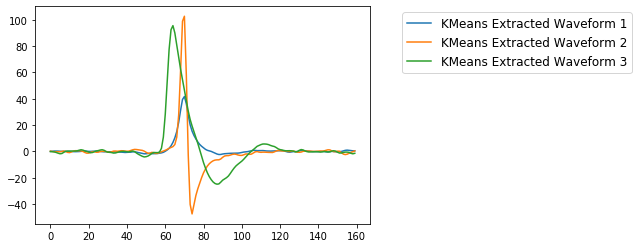

In [745]:
# lets see what this looks like with three clusters to match our number determined
# by PCA

clusters = 3
plotSpikeType(wave_form, clusters)

#  Conclusions

1. KMeans does a better job than PCA at identifying spike types for this dataset
2. KMeans with 3 clusters seems to be enough to identify the three types of spikes in this dataset, however, the number of neural units being recorded could be higher. This would be indicated by the additional clusters that look like slight shifts of the three identified.
3. Using the elbow method, KMeans with 5 clusters seems to be the best, which indicates that we are recording from five different neurons.

In [598]:
#################################################################################
# This is not needed since PCA gave us the appropriate neuron count of three 


# Now we modify the function so that we can see multple plots for different 
# cluster numbers

def plotSpikeTypes(wave_form, clusters, plotNumber):

    kmeans = KMeans(n_clusters=clusters, random_state=42)
    ypred = kmeans.fit_predict(wave_form)
    
    means_by_spike_type = np.zeros((clusters,wave_form.shape[1]))
    number_of_each_spike = np.zeros((clusters))

    for spike_type in range(clusters):
        for row in range(wave_form.shape[0]):
            if (int(spike_type) == ypred[row]):
                number_of_each_spike[spike_type] = number_of_each_spike[spike_type] + 1
                means_by_spike_type[spike_type,:] = wave_form[row,:] + means_by_spike_type[spike_type,:]

    for spike_type in range(clusters):
        means_by_spike_type[spike_type,:] = means_by_spike_type[spike_type,:]/number_of_each_spike[spike_type]
        
    for spike_type in range(clusters):
        ax[plotNumber].plot(means_by_spike_type[spike_type,:], label = 'KMeans Extracted Waveform ' + str(spike_type + 1))
        ax[plotNumber].set_title('Number of clusters: ' + str(clusters))
        ax[plotNumber].legend(bbox_to_anchor=(1.5, 1), loc='upper right', fontsize='large')

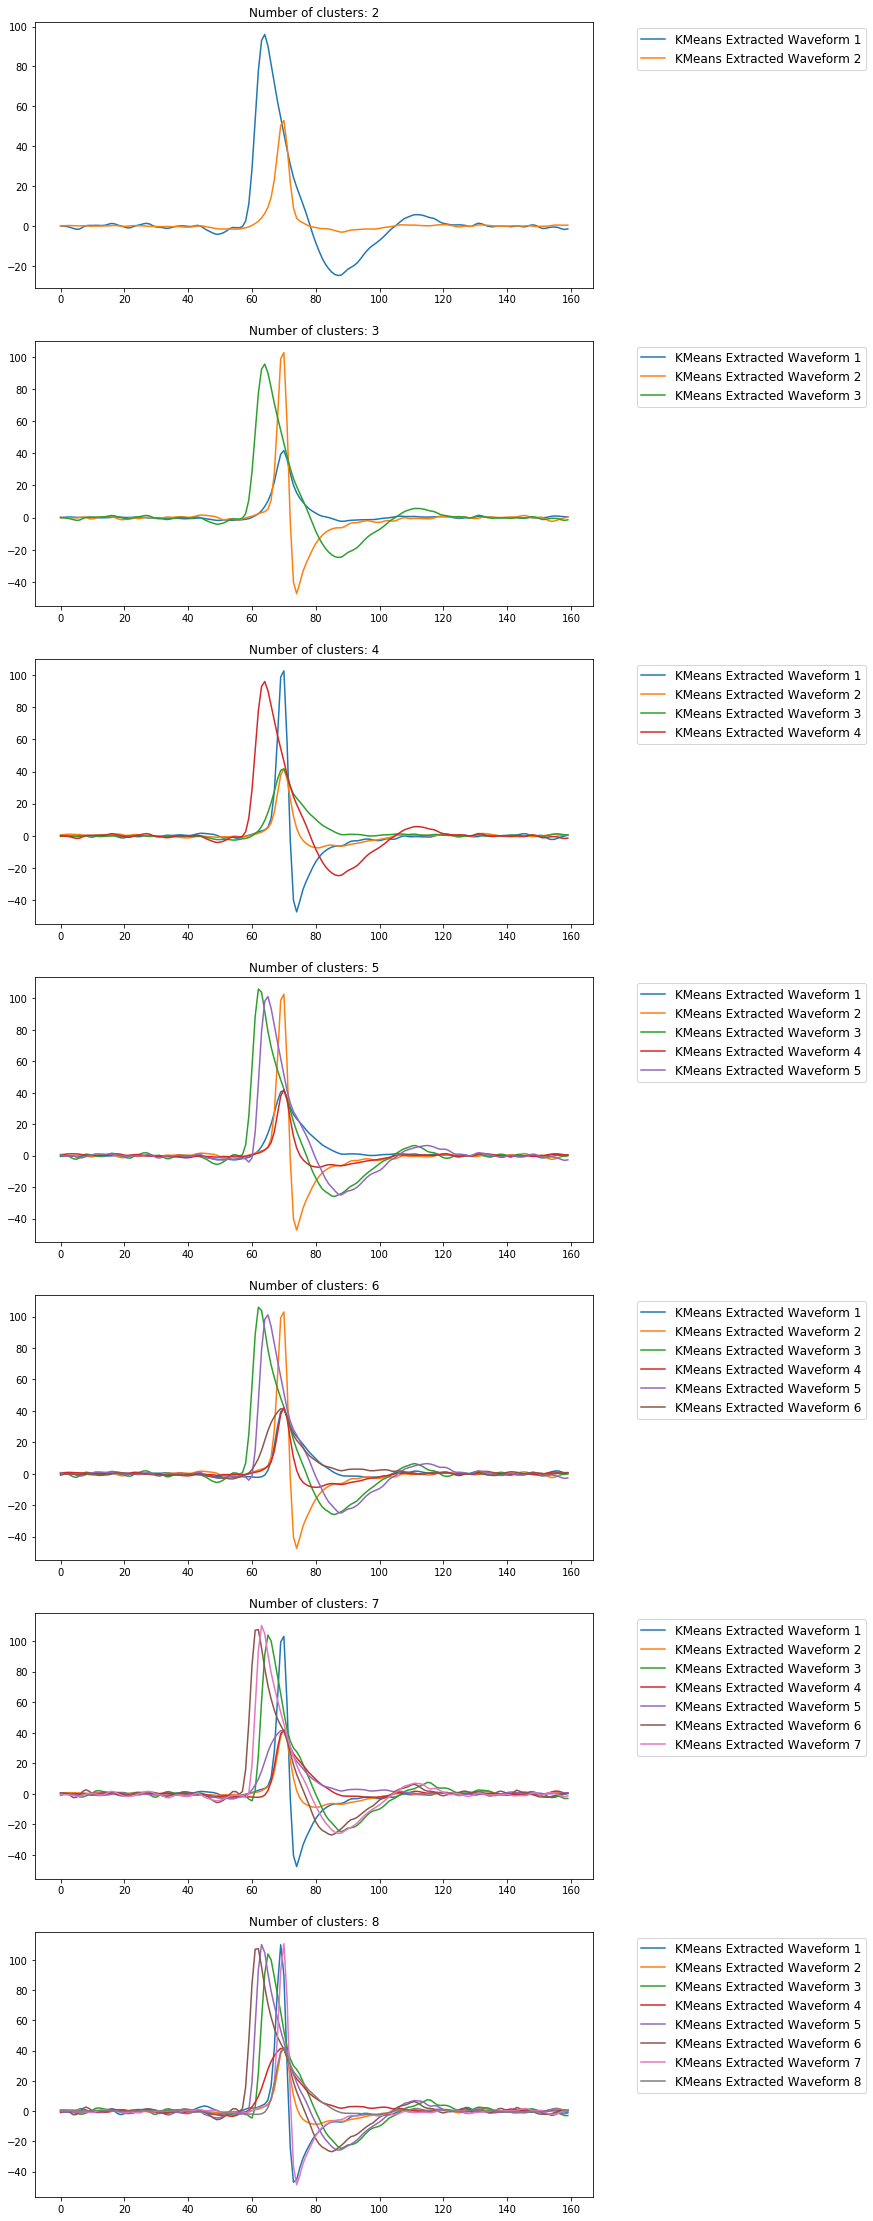

In [600]:
lowerbound = 2 # minimum types of spikes we want to distinguish
upperbound = 8 # maximum types of spikes we want to distinguish
numberOfModels = upperbound-lowerbound 

fig, ax = plt.subplots(nrows=numberOfModels+1, ncols=1, figsize=(10,40))
for plotNumber in range(numberOfModels+1):
    clusters = plotNumber + lowerbound
    plotSpikeTypes(wave_form, clusters, plotNumber)

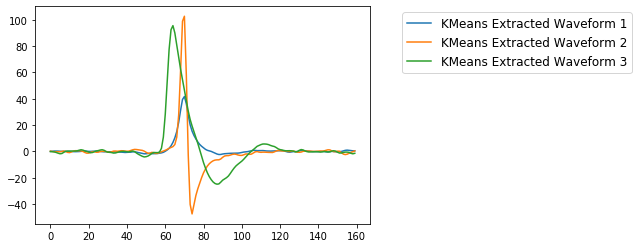

In [597]:
# every cluster identified after the third seems to be a shift of a previously identified cluster
# See the green spike in plot with three clusters, and the green and purple spikes in the plot with 5 clusters

clusters = 3
plotSpikeType(wave_form, clusters)

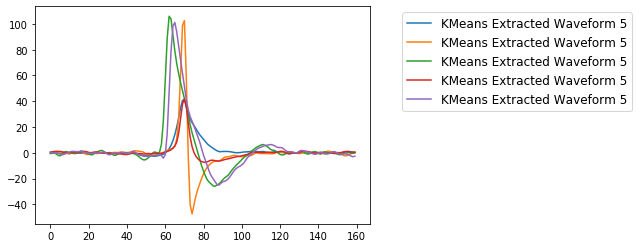

In [590]:
clusters = 5
plotSpikeType(wave_form, clusters)

Clustering results against the first two principle components

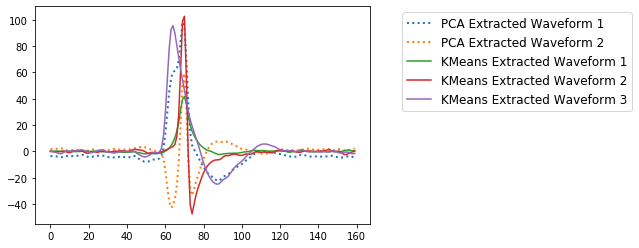

In [601]:
plt.plot((X_reduced[:1].T)/15, linestyle=':', linewidth=2, label='PCA Extracted Waveform 1') 
plt.plot((X_reduced[1:2].T)/15, linestyle=':', linewidth=2, label='PCA Extracted Waveform 2')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', fontsize='large')
clusters = 3
plotSpikeType(wave_form, clusters)

Clustering was able to separate the broad spiking and narrow spiking units while PCA grouped them, as represened by the blue dashed line

In [602]:
Sum_of_squared_distances = []
clusters = range(1,20)
for n in clusters:
    kmeans = KMeans(n_clusters=n)
    ypred = kmeans.fit(wave_form.T)
    Sum_of_squared_distances.append(ypred.inertia_)

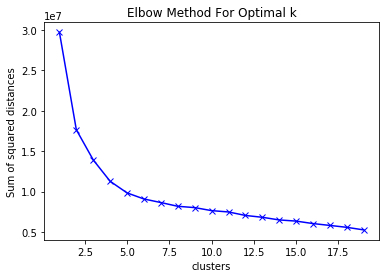

In [603]:
plt.plot(clusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

This appears to indicate that a cluster number of 5 gives us the most distinct sets of waveforms, and adding much more than that is unneccesary. However, the sum of squared distances does continue to decrease all the way to 20 clusters

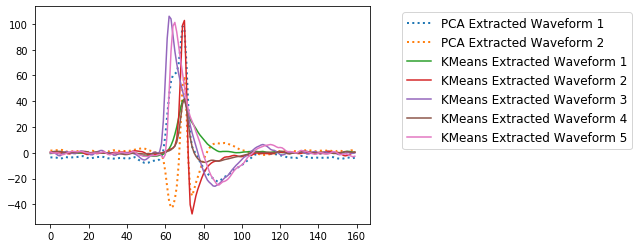

In [604]:
# plot again with 5 clusters and 2 principle components
plt.plot((X_reduced[:1].T)/15, linestyle=':', linewidth=2, label='PCA Extracted Waveform 1') 
plt.plot((X_reduced[1:2].T)/15, linestyle=':', linewidth=2, label='PCA Extracted Waveform 2')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', fontsize='large')
clusters = 5
plotSpikeType(wave_form, clusters)


# Conclusions

1. KMeans does a better job than PCA at identifying spike types for this dataset
2. KMeans with 3 clusters seems to be enough to identify the three types of spikes in this dataset, however, the number of neural units being recorded could be higher. This would be indicated by the additional clusters that look like slight shifts of the three identified.
3. Using the elbow method, KMeans with 5 clusters seems to be the best, which indicates that we are recording from five different neurons.